In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import math
import itertools
import CUDAPython as CP
from scipy.constants import hbar
%matplotlib inline

In [2]:
#sets number of levels (k) and number of fermions (m)
k = 10
m = 5

Generating single fermion energy levels:

In [3]:
def generate_energies(k):
    '''generates ordered array of k distinct energy levels'''
    energies = np.empty(k)
    count=0
    while(count!=k):
        energies[count]=normal(0,1) #samples a normal distribution k times
        count+=1
    #min_ar = np.min(energies) #minimum of energies to use for scaling
    #scaled_ar = energies + abs(min_ar) #scaled array is generated
    return np.sort(energies) #output is a scaled, sorted array of size k

In [4]:
arr = generate_energies(k)

Text(0, 0.5, 'Energy level')

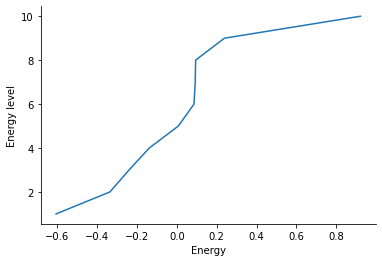

In [5]:
fig, axes = plt.subplots()
axes.plot(arr,np.linspace(1,k,k))
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('Energy')
axes.set_ylabel('Energy level')

Considering m fermions on k single fermion energy levels:

In [6]:
def size(k, m):
    '''determines the number of combination of m fermions on k energy levels'''
    return int(math.factorial(k)/((math.factorial(k-m))*(math.factorial(m))))

def ground_state(k, m):
    '''initialises a ground state based on number of fermions (m) and number of energy levels (k)
    
    e.g. for k=10, m=5:
    ground state is [1,1,1,1,1,0,0,0,0,0]'''
    state = np.zeros(k, dtype=int)
    for i in range(m):
        state[i] = 1
    return state

def permutations(state):
    '''returns a list of possible permutations of a given binary state'''
    return list(set(itertools.permutations(state)))    

In [7]:
state = ground_state(k, m) #initialises ground state

In [8]:
state

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [9]:
states = permutations(state) #list of possible permutations of the ground state

energy_state = {} #empty dict for mapping energies to their corresponding state {energy: state}
energies = np.empty(size(k,m))

for state in range(len(states)): #looping through all possible states
    energy = np.dot(states[state],arr) #computes energy of a given state via a dot product; energy and state arrays can be thought of as vectors -> dot product
    energies[state] = energy
    energy_state[energy] = states[state] #mapping the energy to its given state

sorted_energies = np.sort(energies) #sorting the energies in ascending order

sorted_dict = {} #empty dict to be used in mapping SORTED energies to their states (useful later)

for energy in sorted_energies:
    sorted_dict[energy] = energy_state[energy] #mapping sorted energies to their corresponding states
    
#need to map i to its corresponding state
i_state_map = {}
sorted_states = list(sorted_dict.values())

for i in range(size(k,m)):
    i_state_map[i] = sorted_states[i] #looping through all states and adding them to a dictionary i: state_i

Text(0, 0.5, 'Energy eigenvalues')

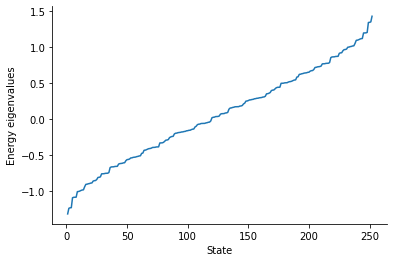

In [10]:
fig, axes = plt.subplots()
axes.plot(np.linspace(1,size(k,m),size(k,m)),sorted_energies)
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('State')
axes.set_ylabel('Energy eigenvalues')

In [11]:
H_0 = np.zeros((size(k,m),size(k,m))) #generating a zero matrix which has dimensions of the number of permutations of the initial state

for i in range(size(k,m)):
    H_0[i][i] = sorted_energies[i] #filling the diagonals with the energy eigenvalues

In [12]:
w = np.empty((size(k,m),size(k,m))) #generating an empty matrix with the same dimensions as H_0

for i in range(size(k,m)):
    for j in range(size(k,m)):
        w[i][j] = normal(0,1) #loops through all possible elements of w and samples a normal distribution, can change variance to change strength of interactions

In [13]:
w_T = np.transpose(w) #determines the transpose of the matrix w

W = (w+w_T)/2 #ensuring that the random matrix W is real and symmetric

H = H_0 + W #H is the hamiltonian with interactions due to the random matrix (non-diagonal)

Diagonalisation of H:

In [14]:
hCUDA = CP.CUDAContext() #obtain CUDA context (only 1 needed)

hCUBLAS = CP.CUBLASContext() 
hCUBLAS.Create() #create CUBLAS context (for basic linear algebra ops)

hCUSolverDense = CP.CUSolverDenseContext()
hCUSolverDense.Create() #create CUSolver Context (for dense matrix ops)

#allocating memory on the CPU to fit a matrix of size size X size
hHostMatrix = CP.CUDAHostMemory()
hHostMatrix.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

hHostVector = CP.CUDAHostMemory()
hHostVector.Allocate1D(CP.CUDANumericSizeRD, size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

for i in range(size(k,m)):
    for j in range(size(k,m)):
        hHostMatrix.WriteRD(CP.CUDAMemoryPosition(i,j,0), H[i][j]) #initialising values

#allocating memory on the GPU to fit a matrix of size size X size
hDeviceMatrixA = CP.CUDADeviceMemory()
hDeviceMatrixA.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m))

hDeviceVectorX = CP.CUDADeviceMemory()
hDeviceVectorX.Allocate1D(CP.CUDANumericSizeRD, size(k,m))

hCUBLAS.SetMatrix(hDeviceMatrixA, CP.CUDAMemoryPosition(), hHostMatrix, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m),size(k,m),1)) #copy memory from CPU to GPU
hCUDA.WaitForCurrentDevice() #sync

#build and setup of solver
hEigenSolver = CP.CUSolverDenseEigenValue(hCUSolverDense)
hEigenSolver.SetMatrixA(hDeviceMatrixA)
hEigenSolver.SetMatrixFillModeA(CP.CUBLASContextFillMode.UPPER)
hEigenSolver.SetVectorX(hDeviceVectorX)
hEigenSolver.SetAlgorithm(CP.CUSolverDenseEigenValueAlgorithm.QR) #householder reduction method???
hEigenSolver.ComputeEigenVectors(True)

hEigenSolver.PrepareRD() #allocates workspace memory

#solve and sync
hEigenSolver.SolveRD()
hCUDA.WaitForCurrentDevice()
hEigenSolver.UpdateStateAfterSync()

#copy memory from GPU to CPU
hCUBLAS.GetMatrix(hHostMatrix, CP.CUDAMemoryPosition(), hDeviceMatrixA, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), size(k,m), 1))
hCUDA.WaitForCurrentDevice()

hCUBLAS.GetVector(hHostVector, CP.CUDAMemoryPosition(), hDeviceVectorX, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), 1, 1))
hCUDA.WaitForCurrentDevice()

hPos = CP.CUDAMemoryPosition()

D = np.zeros((size(k,m), size(k,m))) #initialising matrix to be used to store the eigenvalues as diagonal elements
P = np.zeros((size(k,m), size(k,m))) #initialising basis change matrix (H=PDP^-1)

for hPos.iX in range(size(k,m)):
    D[hPos.iX][hPos.iX] = hHostVector.ReadRD(hPos) #sets the diagonal elements of the matrix to the eigenvalues computed using the above algorithm

#need to prepare P matrix using the eigenvectors given by the above algorithm
for hPos.iY in range(size(k,m)):
    for hPos.iX in range(size(k,m)):
        P[hPos.iY][hPos.iX] = hHostMatrix.ReadRD(hPos)

P_T = np.transpose(P)

#free memory and destroy contexts
hDeviceVectorX.Free()
hDeviceMatrixA.Free()
hHostVector.Free()
hHostMatrix.Free()

hCUSolverDense.Destroy()
hCUBLAS.Destroy()

In [15]:
#need time evolution of the D matrix
def D_evo(t):
    '''Function that produces the D matrix for a given time t (time evolution of D matrix)'''
    D_ev = np.zeros((size(k,m), size(k,m)), dtype=complex)
    
    for x in range(size(k,m)):
        D_ev[x][x] = np.exp(-1j*D[x][x]*t/hbar) #calculates time evolution of the diagonal elements
    return D_ev

In [16]:
#matrix multiplication using CUDA is stored within the test folder
#had issues with converting CUDAComplex64 type back to default python dtype
#found that matmult using numpy was fast enough to be used (avoided the issue with the dtypes)

In [17]:
def V_t(t):
    '''Evolution operator at time t'''
    D_exp = D_evo(t) #evolution matrix for a time t
    left_mat = np.matmul(P, D_exp) #multiplying P*e^D
    return np.matmul(left_mat, P_T) #multiplying above by P_T

In [18]:
def coef(dt, it, init_state):
    '''Returns an array of weighted coefficients for an evolved state for a given time step dt, the iteration it, and some initial state init_state'''
    evolved_state = V_t(dt*it)[init_state] #calculates evolution of the state and extracts the final step
    evolved_state_conj = np.conj(evolved_state) #calculates the complex conjugate of the coefficients
    coefficients = np.empty(size(k,m))
    
    for i in range(size(k,m)):
        coefficients[i] = np.dot(evolved_state[i].real, evolved_state_conj[i].real) + np.dot(evolved_state[i].imag, evolved_state_conj[i].imag) #calculates the inner product of the evolved state and its complex conjugate
    return coefficients

In [19]:
def occupation_number(dt, it, init_state, lev):
    '''Evaluates the occupation number for a given level lev'''
    _sum = 0
    coefs = coef(dt, it, init_state) #calls function that calculates the weightings of each state
    
    for i in range(size(k,m)):
        _sum += np.abs(coefs[i])*i_state_map[i][lev] #dot product between the weights and states
    return _sum

In [20]:
def plot_init_state(energies, state):
    '''Function that displays a plot of a given state'''
    fig, axes = plt.subplots(figsize=((6,12)))
    
    axes.hlines(energies,0,1,'r', zorder=1, label='Energy level')
    axes.scatter(np.full(int(len(energies)/2), 0.5), [energies[i] for i in range(len(energies)) if state[i]==1], color='b', zorder=2, label='Occupied state')
    axes.scatter(np.full(int(len(energies)/2), 0.5), [energies[i] for i in range(len(energies)) if state[i]==0], color='b', facecolor='none',  zorder=2, label='Empty state')
  
    axes.spines['bottom'].set_color('none')
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.set_xticks([])
    axes.set_yticks(energies)
    axes.set_ylabel('Single fermion levels')
    axes.legend()
    return

In [21]:
state = sorted_states[67]

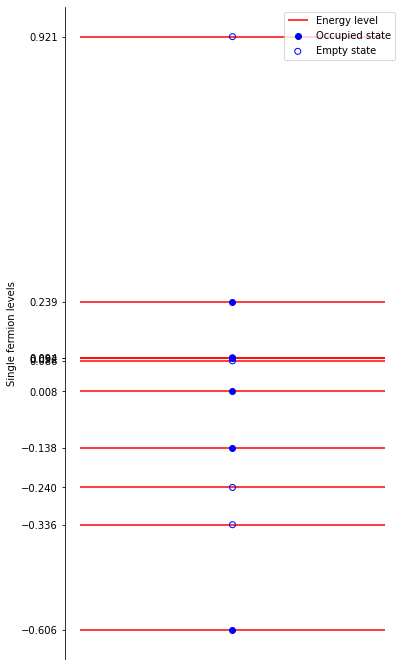

In [22]:

plot_init_state(arr, state)

In [23]:
t = np.empty(252)
k0 = np.empty(252)
k1 = np.empty(252)
k2 = np.empty(252)
k3 = np.empty(252)
k4 = np.empty(252)
k5 = np.empty(252)
k6 = np.empty(252)
k7 = np.empty(252)
k8 = np.empty(252)
k9 = np.empty(252)
dt = hbar/1000

In [24]:
for i in range(252):
    t[i] = dt*i
    k0[i] = occupation_number(dt, i, 67, 0)
    k1[i] = occupation_number(dt, i, 67, 1)
    k2[i] = occupation_number(dt, i, 67, 2)
    k3[i] = occupation_number(dt, i, 67, 3)
    k4[i] = occupation_number(dt, i, 67, 4)
    k5[i] = occupation_number(dt, i, 67, 5)
    k6[i] = occupation_number(dt, i, 67, 6)
    k7[i] = occupation_number(dt, i, 67, 7)
    k8[i] = occupation_number(dt, i, 67, 8)
    k9[i] = occupation_number(dt, i, 67, 9)

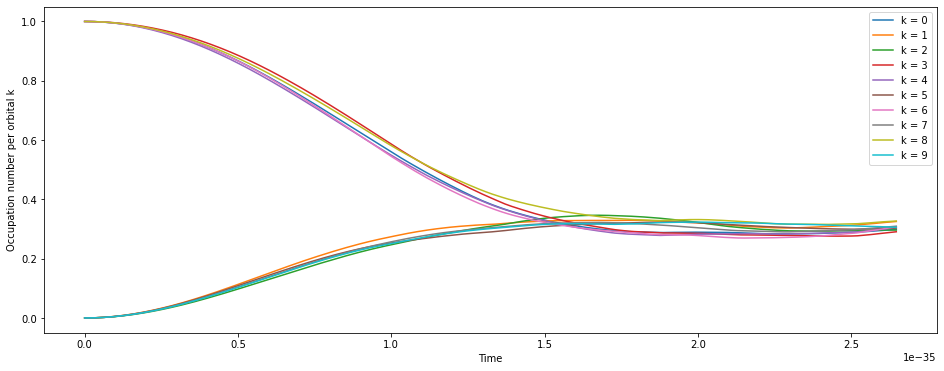

In [25]:
fig, axes = plt.subplots(figsize=((16,6)))
axes.plot(t,k0, label='k = 0')
axes.plot(t,k1, label='k = 1')
axes.plot(t,k2, label='k = 2')
axes.plot(t,k3, label='k = 3')
axes.plot(t,k4, label='k = 4')
axes.plot(t,k5, label='k = 5')
axes.plot(t,k6, label='k = 6')
axes.plot(t,k7, label='k = 7')
axes.plot(t,k8, label='k = 8')
axes.plot(t,k9, label='k = 9')
axes.set_xlabel("Time")
axes.set_ylabel("Occupation number per orbital k")
axes.legend()

In [26]:
#V_t(0)